In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
pokemon_df = pd.read_csv("pokemon.csv")
pokemon_df.head()

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [3]:
pokemon_df = pokemon_df.set_index("#")
pokemon_df.head()

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
#,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False


In [4]:
combats_df = pd.read_csv("combats.csv")
combats_df.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668
3,237,683,683
4,151,231,151


In [5]:
pokemon_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1 to 800
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        799 non-null    object
 1   Type 1      800 non-null    object
 2   Type 2      414 non-null    object
 3   HP          800 non-null    int64 
 4   Attack      800 non-null    int64 
 5   Defense     800 non-null    int64 
 6   Sp. Atk     800 non-null    int64 
 7   Sp. Def     800 non-null    int64 
 8   Speed       800 non-null    int64 
 9   Generation  800 non-null    int64 
 10  Legendary   800 non-null    bool  
dtypes: bool(1), int64(7), object(3)
memory usage: 69.5+ KB


In [6]:
pokemon_df["Type 2"].value_counts(dropna=False)

NaN         386
Flying       97
Ground       35
Poison       34
Psychic      33
Fighting     26
Grass        25
Fairy        23
Steel        22
Dark         20
Dragon       18
Ghost        14
Ice          14
Water        14
Rock         14
Fire         12
Electric      6
Normal        4
Bug           3
Name: Type 2, dtype: int64

In [7]:
pokemon_df["Type 2"].fillna("empty", inplace=True)
pokemon_df["Type 2"].value_counts()

empty       386
Flying       97
Ground       35
Poison       34
Psychic      33
Fighting     26
Grass        25
Fairy        23
Steel        22
Dark         20
Dragon       18
Ghost        14
Ice          14
Water        14
Rock         14
Fire         12
Electric      6
Normal        4
Bug           3
Name: Type 2, dtype: int64

In [8]:
print(pokemon_df.dtypes)
print("-" * 30)
print(combats_df.dtypes)

Name          object
Type 1        object
Type 2        object
HP             int64
Attack         int64
Defense        int64
Sp. Atk        int64
Sp. Def        int64
Speed          int64
Generation     int64
Legendary       bool
dtype: object
------------------------------
First_pokemon     int64
Second_pokemon    int64
Winner            int64
dtype: object


In [109]:
pokemon_df["Type 1"] = pokemon_df["Type 1"].astype("category")
pokemon_df["Type 2"] = pokemon_df["Type 2"].astype("category")
pokemon_df["Legendary"] = pokemon_df["Legendary"].astype("int")
print(pokemon_df.dtypes)

Type 1        category
Type 2        category
HP             float64
Attack         float64
Defense        float64
Sp. Atk        float64
Sp. Def        float64
Speed          float64
Generation     float64
Legendary        int32
Bug              int32
Dark             int32
Dragon           int32
Electric         int32
Fairy            int32
Fighting         int32
Fire             int32
Flying           int32
Ghost            int32
Grass            int32
Ground           int32
Ice              int32
Normal           int32
Poison           int32
Psychic          int32
Rock             int32
Steel            int32
Water            int32
empty            int32
dtype: object


In [10]:
df_type1_onehot = pd.get_dummies(pokemon_df["Type 1"])
df_type1_onehot.head()

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water
#,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [11]:
df_type2_onehot = pd.get_dummies(pokemon_df["Type 2"])
df_type2_onehot.head()

,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,empty
#,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [12]:
combine_df_onehot = df_type1_onehot.add(df_type2_onehot, fill_value=0).astype("int")

pd.options.display.max_columns = 30
pokemon_df = pokemon_df.join(combine_df_onehot)
pokemon_df.head()

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,empty
#,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,Charmander,Fire,empty,39,52,43,60,50,65,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [13]:
dict(enumerate(pokemon_df["Type 1"].cat.categories))

{0: 'Bug',
 1: 'Dark',
 2: 'Dragon',
 3: 'Electric',
 4: 'Fairy',
 5: 'Fighting',
 6: 'Fire',
 7: 'Flying',
 8: 'Ghost',
 9: 'Grass',
 10: 'Ground',
 11: 'Ice',
 12: 'Normal',
 13: 'Poison',
 14: 'Psychic',
 15: 'Rock',
 16: 'Steel',
 17: 'Water'}

In [14]:
pokemon_df["Type 1"].cat.codes.head(10)

#
1      9
2      9
3      9
4      9
5      6
6      6
7      6
8      6
9      6
10    17
dtype: int8

In [15]:
pokemon_df["Type 1"] = pokemon_df["Type 1"].cat.codes
pokemon_df["Type 2"] = pokemon_df["Type 2"].cat.codes
pokemon_df.head()

,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,empty
#,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Bulbasaur,9,13,45,49,49,65,65,45,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,Ivysaur,9,13,60,62,63,80,80,60,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,Venusaur,9,13,80,82,83,100,100,80,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,Mega Venusaur,9,13,80,100,123,122,120,80,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,Charmander,6,18,39,52,43,60,50,65,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [16]:
pokemon_df.drop("Name", axis=1, inplace=True)
pokemon_df

,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,empty
#,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,9,13,45,49,49,65,65,45,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,9,13,60,62,63,80,80,60,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,9,13,80,82,83,100,100,80,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,9,13,80,100,123,122,120,80,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,6,18,39,52,43,60,50,65,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
796,15,4,50,100,150,100,150,50,6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
797,15,4,50,160,110,160,110,110,6,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0
798,14,8,80,110,60,150,130,70,6,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0


In [17]:
combats_df["Winner"] = combats_df.apply(lambda x: 0 if x.Winner == x.First_pokemon else 1, axis=1)
combats_df.head()

,First_pokemon,Second_pokemon,Winner
0,266,298,1
1,702,701,1
2,191,668,1
3,237,683,1
4,151,231,0


In [23]:
data_num = combats_df.shape[0]
indexes = np.random.permutation(data_num)

train_indexes = indexes[:int(data_num*0.6)]
val_indexes = indexes[int(data_num*0.6):int(data_num*0.8)]
test_indexes = indexes[int(data_num*0.6):]

train_data = combats_df.loc[train_indexes]
val_data = combats_df.loc[val_indexes]
test_data = combats_df.loc[test_indexes]

In [24]:
pokemon_df["Type 1"] = pokemon_df["Type 1"] / 19
pokemon_df["Type 2"] = pokemon_df["Type 2"] / 19

mean = pokemon_df.loc[:, "HP":"Generation"].mean()
std = pokemon_df.loc[:, "HP":"Generation"].std()

print(mean)
print(std)

pokemon_df.loc[:, "HP":"Generation"] = (pokemon_df.loc[:, "HP":"Generation"] - mean) / std
pokemon_df.head()

HP            69.25875
Attack        79.00125
Defense       73.84250
Sp. Atk       72.82000
Sp. Def       71.90250
Speed         68.27750
Generation     3.32375
dtype: float64
HP            25.534669
Attack        32.457366
Defense       31.183501
Sp. Atk       32.722294
Sp. Def       27.828916
Speed         29.060474
Generation     1.661290
dtype: float64


,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Bug,Dark,Dragon,Electric,Fairy,Fighting,Fire,Flying,Ghost,Grass,Ground,Ice,Normal,Poison,Psychic,Rock,Steel,Water,empty
#,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.473684,0.684211,-0.950032,-0.924328,-0.796655,-0.238981,-0.248033,-0.801002,-1.398762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
2,0.473684,0.684211,-0.362595,-0.523803,-0.347700,0.219422,0.290974,-0.284837,-1.398762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
3,0.473684,0.684211,0.420654,0.092390,0.293665,0.830626,1.009651,0.403383,-1.398762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
4,0.473684,0.684211,0.420654,0.646964,1.576395,1.502951,1.728328,0.403383,-1.398762,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0
5,0.315789,0.947368,-1.185007,-0.831899,-0.989065,-0.391782,-0.787041,-0.112782,-1.398762,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1


In [25]:
print(pokemon_df.loc[:, "HP":"Generation"].mean())
print(pokemon_df.loc[:, "HP":"Generation"].std())

HP           -5.410949e-16
Attack        2.553513e-17
Defense       5.828671e-18
Sp. Atk       2.295386e-16
Sp. Def      -2.584044e-16
Speed        -1.208669e-16
Generation    2.837175e-15
dtype: float64
HP            1.0
Attack        1.0
Defense       1.0
Sp. Atk       1.0
Sp. Def       1.0
Speed         1.0
Generation    1.0
dtype: float64


In [58]:
x_train_index = np.array(train_data.drop("Winner", axis=1))
x_val_index = np.array(val_data.drop("Winner", axis=1))
x_test_index = np.array(test_data.drop("Winner", axis=1))

print(x_train_index)

[[155 242]
 [195  97]
 [310 647]
 ...
 [197 678]
 [357 189]
 [702 599]]


In [59]:
y_train = np.array(train_data["Winner"])
y_val = np.array(val_data["Winner"])
y_test = np.array(test_data["Winner"])

print(y_train)

[0 1 1 ... 0 0 0]


## 第一種：屬性以數值表示

In [32]:
pokemon_data_normal = np.array(pokemon_df.loc[:, :"Legendary"])
print(pokemon_data_normal.shape)

x_train_normal = pokemon_data_normal[x_train_index-1].reshape((-1, 20))
x_val_normal = pokemon_data_normal[x_val_index-1].reshape((-1, 20))
x_test_normal = pokemon_data_normal[x_test_index-1].reshape((-1, 20))
print(x_train_normal.shape)

(800, 10)
(30000, 20)


In [35]:
inputs = keras.Input(shape=(20, ))
x = layers.Dense(64, activation="relu") (inputs)
x = layers.Dropout(0.3) (x)
x = layers.Dense(64, activation="relu") (x)
x = layers.Dropout(0.3) (x)
x = layers.Dense(16, activation="relu") (x)
x = layers.Dropout(0.3) (x)
outputs = layers.Dense(1, activation="sigmoid") (x)

model_1 = keras.Model(inputs, outputs, name="model-1")
model_1.summary()

Model: "model-1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1344      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0   

In [37]:
model_1.compile(keras.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.BinaryAccuracy()])

In [39]:
model_dir = "logs/models"
if not os.path.exists(model_dir):
    print("new dir!")
    os.makedirs(model_dir)

new dir!


In [40]:
log_dir = os.path.join("logs", "model-1")

model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir+"/best-model-1.h5", monitor="val_binary_accuracy",
                                             save_best_only=True, mode="max")

In [41]:
history_1 = model_1.fit(x_train_normal, y_train, batch_size=64, epochs=200,
                        validation_data=(x_val_normal, y_val), callbacks=[model_cbk, model_mckp])

Epoch 1/200
469/469 [==============================] - 5s 8ms/step - loss: 0.4391 - binary_accuracy: 0.8212 - val_loss: 0.3150 - val_binary_accuracy: 0.9009
Epoch 2/200
469/469 [==============================] - 2s 5ms/step - loss: 0.3387 - binary_accuracy: 0.8917 - val_loss: 0.2554 - val_binary_accuracy: 0.9257
Epoch 3/200
469/469 [==============================] - 2s 5ms/step - loss: 0.2825 - binary_accuracy: 0.9090 - val_loss: 0.2092 - val_binary_accuracy: 0.9340
Epoch 4/200
469/469 [==============================] - 2s 5ms/step - loss: 0.2509 - binary_accuracy: 0.9189 - val_loss: 0.1949 - val_binary_accuracy: 0.9381
Epoch 5/200
469/469 [==============================] - 2s 5ms/step - loss: 0.2306 - binary_accuracy: 0.9259 - val_loss: 0.1814 - val_binary_accuracy: 0.9391
Epoch 6/200
469/469 [==============================] - 2s 5ms/step - loss: 0.2196 - binary_accuracy: 0.9287 - val_loss: 0.1762 - val_binary_accuracy: 0.9437
Epoch 7/200
469/469 [==============================] - 2s 

Epoch 53/200
469/469 [==============================] - 3s 6ms/step - loss: 0.1698 - binary_accuracy: 0.9461 - val_loss: 0.1582 - val_binary_accuracy: 0.9480
Epoch 54/200
469/469 [==============================] - 3s 7ms/step - loss: 0.1702 - binary_accuracy: 0.9460 - val_loss: 0.1546 - val_binary_accuracy: 0.9515
Epoch 55/200
469/469 [==============================] - 4s 8ms/step - loss: 0.1653 - binary_accuracy: 0.9466 - val_loss: 0.1559 - val_binary_accuracy: 0.9502
Epoch 56/200
469/469 [==============================] - 4s 8ms/step - loss: 0.1711 - binary_accuracy: 0.9466 - val_loss: 0.1567 - val_binary_accuracy: 0.9497
Epoch 57/200
469/469 [==============================] - 3s 7ms/step - loss: 0.1692 - binary_accuracy: 0.9467 - val_loss: 0.1573 - val_binary_accuracy: 0.9490
Epoch 58/200
469/469 [==============================] - 3s 7ms/step - loss: 0.1674 - binary_accuracy: 0.9458 - val_loss: 0.1550 - val_binary_accuracy: 0.9491
Epoch 59/200
469/469 [==============================

Epoch 105/200
469/469 [==============================] - 3s 6ms/step - loss: 0.1601 - binary_accuracy: 0.9480 - val_loss: 0.1576 - val_binary_accuracy: 0.9498
Epoch 106/200
469/469 [==============================] - 3s 6ms/step - loss: 0.1600 - binary_accuracy: 0.9469 - val_loss: 0.1564 - val_binary_accuracy: 0.9503
Epoch 107/200
469/469 [==============================] - 3s 6ms/step - loss: 0.1556 - binary_accuracy: 0.9499 - val_loss: 0.1555 - val_binary_accuracy: 0.9503
Epoch 108/200
469/469 [==============================] - 3s 6ms/step - loss: 0.1574 - binary_accuracy: 0.9487 - val_loss: 0.1516 - val_binary_accuracy: 0.9509
Epoch 109/200
469/469 [==============================] - 3s 6ms/step - loss: 0.1599 - binary_accuracy: 0.9486 - val_loss: 0.1503 - val_binary_accuracy: 0.9504
Epoch 110/200
469/469 [==============================] - 3s 6ms/step - loss: 0.1552 - binary_accuracy: 0.9486 - val_loss: 0.1507 - val_binary_accuracy: 0.9515
Epoch 111/200
469/469 [=======================

469/469 [==============================] - 3s 6ms/step - loss: 0.1555 - binary_accuracy: 0.9492 - val_loss: 0.1512 - val_binary_accuracy: 0.9512
Epoch 157/200
469/469 [==============================] - 3s 6ms/step - loss: 0.1529 - binary_accuracy: 0.9500 - val_loss: 0.1519 - val_binary_accuracy: 0.9522
Epoch 158/200
469/469 [==============================] - 3s 6ms/step - loss: 0.1518 - binary_accuracy: 0.9496 - val_loss: 0.1527 - val_binary_accuracy: 0.9520
Epoch 159/200
469/469 [==============================] - 3s 6ms/step - loss: 0.1510 - binary_accuracy: 0.9501 - val_loss: 0.1530 - val_binary_accuracy: 0.9499
Epoch 160/200
469/469 [==============================] - 3s 6ms/step - loss: 0.1562 - binary_accuracy: 0.9486 - val_loss: 0.1529 - val_binary_accuracy: 0.9508
Epoch 161/200
469/469 [==============================] - 3s 6ms/step - loss: 0.1522 - binary_accuracy: 0.9494 - val_loss: 0.1536 - val_binary_accuracy: 0.9518
Epoch 162/200
469/469 [==============================] - 3s 

## 第二種：屬性以one hot表示

In [53]:
pokemon_data_onehot = np.array(pokemon_df.loc[:, "HP":])
print(pokemon_data_onehot.shape)

x_train_onehot = pokemon_data_onehot[x_train_index-1].reshape((-1, 54))
x_val_onehot = pokemon_data_onehot[x_val_index-1].reshape((-1, 54))
x_test_onehot = pokemon_data_onehot[x_test_index-1].reshape((-1, 54))
print(x_train_onehot.shape)

(800, 27)
(30000, 54)


In [54]:
inputs = keras.Input(shape=(54, ))
x = layers.Dense(64, activation="relu") (inputs)
x = layers.Dropout(0.3) (x)
x = layers.Dense(64, activation="relu") (x)
x = layers.Dropout(0.3) (x)
x = layers.Dense(16, activation="relu") (x)
x = layers.Dropout(0.3) (x)
outputs = layers.Dense(1, activation="sigmoid") (x)

model_2 = keras.Model(inputs, outputs, name="model-2")
model_2.summary()

Model: "model-2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 54)]              0         
_________________________________________________________________
dense_8 (Dense)              (None, 64)                3520      
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 16)                1040      
_________________________________________________________________
dropout_8 (Dropout)          (None, 16)                0   

In [55]:
model_2.compile(keras.optimizers.Adam(), loss=keras.losses.BinaryCrossentropy(), metrics=[keras.metrics.BinaryAccuracy()])

In [56]:
model_dir = "logs/models"
if not os.path.exists(model_dir):
    print("new dir!")
    os.makedirs(model_dir)

In [66]:
log_dir = os.path.join("logs", "model-2")

model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir+"/best-model-2.h5", monitor="val_binary_accuracy",
                                             save_best_only=True, mode="max")

In [67]:
history_2 = model_2.fit(x_train_onehot, y_train, batch_size=64, epochs=200,
                        validation_data=(x_val_onehot, y_val), callbacks=[model_cbk, model_mckp])

Epoch 1/200
469/469 [==============================] - 4s 8ms/step - loss: 0.2984 - binary_accuracy: 0.8991 - val_loss: 0.2137 - val_binary_accuracy: 0.9269
Epoch 2/200
469/469 [==============================] - 3s 7ms/step - loss: 0.2559 - binary_accuracy: 0.9100 - val_loss: 0.1899 - val_binary_accuracy: 0.9318
Epoch 3/200
469/469 [==============================] - 3s 7ms/step - loss: 0.2307 - binary_accuracy: 0.9184 - val_loss: 0.1794 - val_binary_accuracy: 0.9349
Epoch 4/200
469/469 [==============================] - 3s 7ms/step - loss: 0.2089 - binary_accuracy: 0.9240 - val_loss: 0.1620 - val_binary_accuracy: 0.9406
Epoch 5/200
469/469 [==============================] - 3s 7ms/step - loss: 0.2005 - binary_accuracy: 0.9262 - val_loss: 0.1593 - val_binary_accuracy: 0.9390
Epoch 6/200
469/469 [==============================] - 3s 6ms/step - loss: 0.1892 - binary_accuracy: 0.9301 - val_loss: 0.1515 - val_binary_accuracy: 0.9402
Epoch 7/200
469/469 [==============================] - 3s 

469/469 [==============================] - 6s 13ms/step - loss: 0.0936 - binary_accuracy: 0.9620 - val_loss: 0.0965 - val_binary_accuracy: 0.9649
Epoch 53/200
469/469 [==============================] - 6s 12ms/step - loss: 0.1027 - binary_accuracy: 0.9592 - val_loss: 0.1000 - val_binary_accuracy: 0.9615
Epoch 54/200
469/469 [==============================] - 6s 13ms/step - loss: 0.0959 - binary_accuracy: 0.9610 - val_loss: 0.0929 - val_binary_accuracy: 0.9642
Epoch 55/200
469/469 [==============================] - 5s 10ms/step - loss: 0.0986 - binary_accuracy: 0.9612 - val_loss: 0.0951 - val_binary_accuracy: 0.9633
Epoch 56/200
469/469 [==============================] - 4s 8ms/step - loss: 0.1012 - binary_accuracy: 0.9594 - val_loss: 0.0963 - val_binary_accuracy: 0.9636
Epoch 57/200
469/469 [==============================] - 4s 9ms/step - loss: 0.0975 - binary_accuracy: 0.9606 - val_loss: 0.0895 - val_binary_accuracy: 0.9647
Epoch 58/200
469/469 [==============================] - 5s 10

Epoch 104/200
469/469 [==============================] - 3s 7ms/step - loss: 0.0834 - binary_accuracy: 0.9667 - val_loss: 0.0917 - val_binary_accuracy: 0.9674
Epoch 105/200
469/469 [==============================] - 4s 8ms/step - loss: 0.0836 - binary_accuracy: 0.9668 - val_loss: 0.0980 - val_binary_accuracy: 0.9654
Epoch 106/200
469/469 [==============================] - 3s 7ms/step - loss: 0.0824 - binary_accuracy: 0.9670 - val_loss: 0.0944 - val_binary_accuracy: 0.9663
Epoch 107/200
469/469 [==============================] - 4s 8ms/step - loss: 0.0878 - binary_accuracy: 0.9640 - val_loss: 0.0866 - val_binary_accuracy: 0.9668
Epoch 108/200
469/469 [==============================] - 4s 7ms/step - loss: 0.0791 - binary_accuracy: 0.9686 - val_loss: 0.1071 - val_binary_accuracy: 0.9638
Epoch 109/200
469/469 [==============================] - 4s 8ms/step - loss: 0.0839 - binary_accuracy: 0.9660 - val_loss: 0.0905 - val_binary_accuracy: 0.9665
Epoch 110/200
469/469 [=======================

469/469 [==============================] - 4s 8ms/step - loss: 0.0762 - binary_accuracy: 0.9700 - val_loss: 0.0903 - val_binary_accuracy: 0.9663
Epoch 156/200
469/469 [==============================] - 4s 8ms/step - loss: 0.0755 - binary_accuracy: 0.9702 - val_loss: 0.0899 - val_binary_accuracy: 0.9668
Epoch 157/200
469/469 [==============================] - 4s 8ms/step - loss: 0.0772 - binary_accuracy: 0.9694 - val_loss: 0.0839 - val_binary_accuracy: 0.9681
Epoch 158/200
469/469 [==============================] - 3s 7ms/step - loss: 0.0765 - binary_accuracy: 0.9702 - val_loss: 0.0898 - val_binary_accuracy: 0.9666
Epoch 159/200
469/469 [==============================] - 3s 7ms/step - loss: 0.0771 - binary_accuracy: 0.9695 - val_loss: 0.0900 - val_binary_accuracy: 0.9668
Epoch 160/200
469/469 [==============================] - 4s 8ms/step - loss: 0.0736 - binary_accuracy: 0.9698 - val_loss: 0.0904 - val_binary_accuracy: 0.9672
Epoch 161/200
469/469 [==============================] - 4s 

## 比較兩種模型

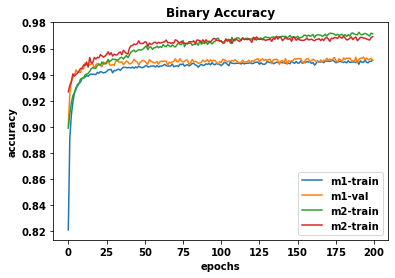

In [69]:
plt.plot(history_1.history["binary_accuracy"], label="m1-train")
plt.plot(history_1.history["val_binary_accuracy"], label="m1-val")
plt.plot(history_2.history["binary_accuracy"], label="m2-train")
plt.plot(history_2.history["val_binary_accuracy"], label="m2-train")
plt.title("Binary Accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()

In [71]:
model_1 = keras.models.load_model(model_dir+"/best-model-1.h5")
model_2 = keras.models.load_model(model_dir+"/best-model-2.h5")

scores_1 = model_1.evaluate(x_test_normal, y_test)
scores_2 = model_2.evaluate(x_test_onehot, y_test)
print(f"model-1 acc:", scores_1[1])
print(f"model-2 acc:", scores_2[1])

625/625 [==============================] - 2s 2ms/step - loss: 0.0901 - binary_accuracy: 0.9683
model-1 acc: 0.9523000121116638
model-2 acc: 0.9682999849319458


## 妙蛙花、噴火龍、水箭龜 大PK

In [78]:
venusaur = np.expand_dims(pokemon_data_onehot[3], axis=0)   # 妙蛙花
charizard = np.expand_dims(pokemon_data_onehot[7], axis=0)  # 噴火龍
blastoise = np.expand_dims(pokemon_data_onehot[12], axis=0) # 水箭龜

pred = model_2.predict(np.concatenate([venusaur, charizard], axis=-1))
winner = "妙蛙花" if pred < 0.5 else "噴火龍"
print(f"pred={pred}, winner is {winner}!")

pred = model_2.predict(np.concatenate([charizard, blastoise], axis=-1))
winner = "噴火龍" if pred < 0.5 else "水箭龜"
print(f"pred={pred}, winner is {winner}!")

pred = model_2.predict(np.concatenate([venusaur, blastoise], axis=-1))
winner = "妙蛙花" if pred < 0.5 else "水箭龜"
print(f"pred={pred}, winner is {winner}!")

pred=[[0.9999558]], winner is 噴火龍!
pred=[[3.8143462e-05]], winner is 噴火龍!
pred=[[0.37881866]], winner is 妙蛙花!


## 隨機抽樣兩隻寶可夢對戰

In [81]:
pokemon_info_df = pd.read_csv("pokemon.csv")
pokemon_info_df

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False
3,4,Mega Venusaur,Grass,Poison,80,100,123,122,120,80,1,False
4,5,Charmander,Fire,NaN,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...
795,796,Diancie,Rock,Fairy,50,100,150,100,150,50,6,True
796,797,Mega Diancie,Rock,Fairy,50,160,110,160,110,110,6,True
797,798,Hoopa Confined,Psychic,Ghost,80,110,60,150,130,70,6,True
798,799,Hoopa Unbound,Psychic,Dark,80,160,60,170,130,80,6,True


In [107]:
two_pokemon = np.random.choice(np.arange(800), size=2, replace=True)
print(two_pokemon)

first_pokemon = two_pokemon[0]
second_pokemon = two_pokemon[1]

[254 343]


In [112]:
first_pokemon_name = pokemon_info_df.iloc[first_pokemon]["Name"]
second_pokemon_name = pokemon_info_df.iloc[second_pokemon]["Name"]

print(f"{first_pokemon_name}({first_pokemon}) vs. {second_pokemon_name}({second_pokemon})")

first_pokemon_data = np.expand_dims(pokemon_data_onehot[first_pokemon], axis=0)   # 妙蛙花
second_pokemon_data = np.expand_dims(pokemon_data_onehot[second_pokemon], axis=0)  # 噴火龍

print(np.concatenate([first_pokemon_data, second_pokemon_data], axis=-1))

pred = model_2.predict(np.concatenate([first_pokemon_data, second_pokemon_data], axis=-1))
winner = first_pokemon_name if pred < 0.5 else second_pokemon_name
print("pred={:.6f}, winner is {}!".format(pred[0][0], winner))

Smeargle(254) vs. Illumise(343)
[[-0.55840747 -1.81780771 -1.24561064 -1.61419    -0.96671032  0.23132796
  -0.79682035  0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          1.          0.          0.          0.
   0.          0.          1.         -0.16678305 -0.98594723 -0.60424582
   0.00550084  0.11130509  0.57543797 -0.19487863  0.          1.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          1.        ]]
pred=1.000000, winner is Illumise!
